In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Flatten, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras import mixed_precision

import keras
import pandas as pd
import os
#import gradio as gr
import numpy as np

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set up directory paths
base_dir = '/content/drive/MyDrive/AI/Skin Cancer/Skin Cancer/combined_images'
img_path = '/content/drive/MyDrive/AI/Skin Cancer/Skin Cancer/combined_images'
metadata_file = '/content/drive/MyDrive/AI/final_labels_df.csv'

In [4]:
# Work with metadata
metadata = pd.read_csv(metadata_file)
labels_dict = {
    row['image_id']: 'melanoma' if row['dx'] == "melanoma" else "not melanoma"
    for _, row in metadata.iterrows()
}
labels_df = pd.DataFrame(list(labels_dict.items()), columns=['image_id', 'dx'])
#labels_df['image_id'] = labels_df['image_id'] + '.jpg'

# Image data generator for preprocessing and augmentation (Use 20% of data for validation)
datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=0.1,
    rescale = 1./255,
    validation_split=0.2)

In [5]:
def create_generator(datagen, subset):
  return datagen.flow_from_dataframe(
      dataframe = labels_df,
      directory = base_dir,
      x_col = 'image_id',
      y_col = 'dx',
      target_size = (224, 224),
      batch_size = 32,
      class_mode = 'binary',
      shuffle = True,
      seed = 46,
      subset = subset
  )

train_generator = create_generator(datagen, 'training')
val_generator = create_generator(datagen, 'validation')

Found 14244 validated image filenames belonging to 2 classes.
Found 3560 validated image filenames belonging to 2 classes.


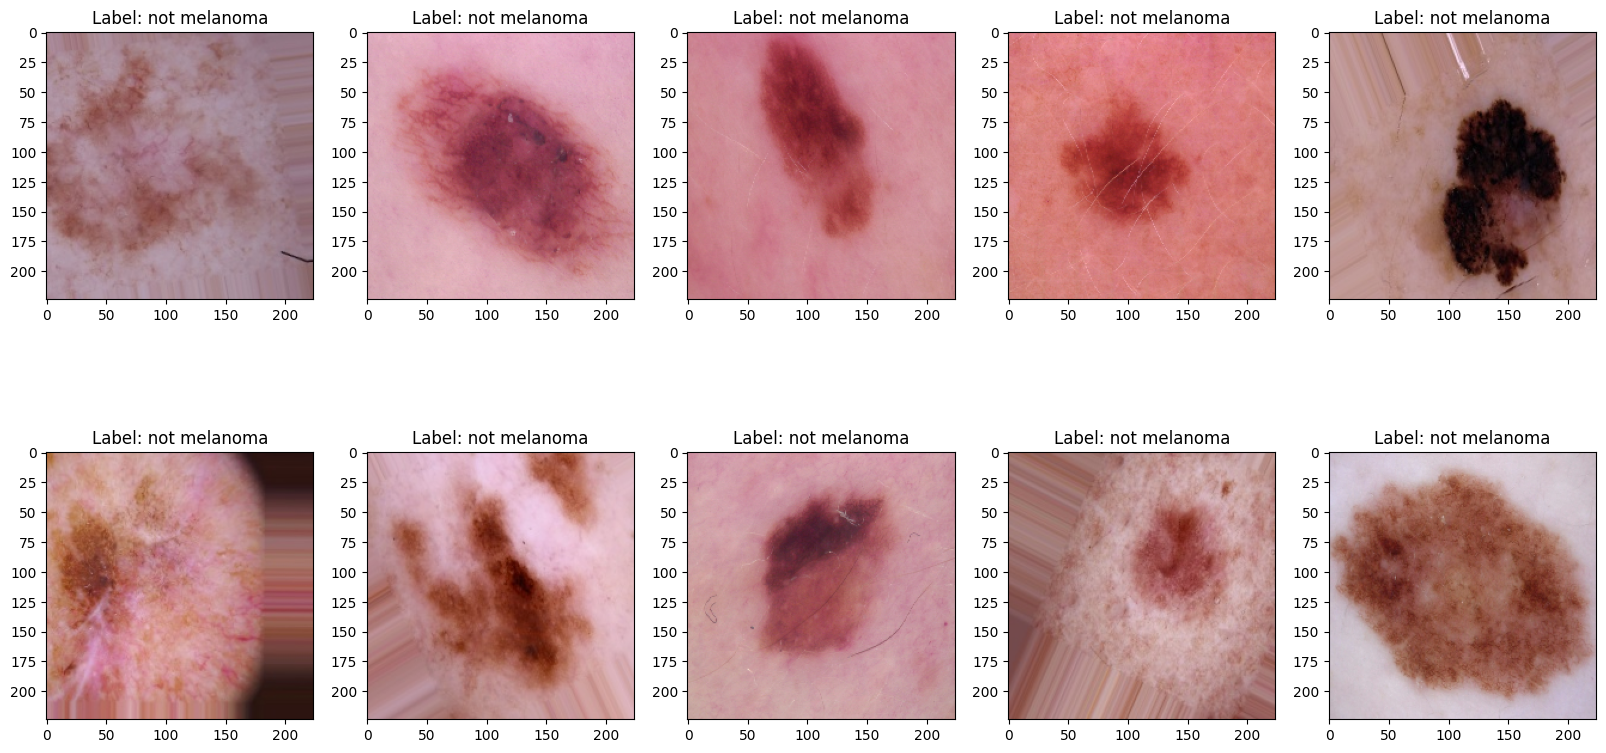

In [ ]:
images, labels = next(train_generator)

plt.figure(figsize=(20, 10))
for i in range(10):
   plt.subplot(2, 5, i + 1)
   plt.imshow(images[i])
   # Get the index of the class with the highest probability
   class_index = np.argmax(labels[i])
   # Map the index to the original label
   original_label = "melanoma" if class_index == 1 else "not melanoma"
   plt.title('Label: {}'.format(original_label))

plt.show()

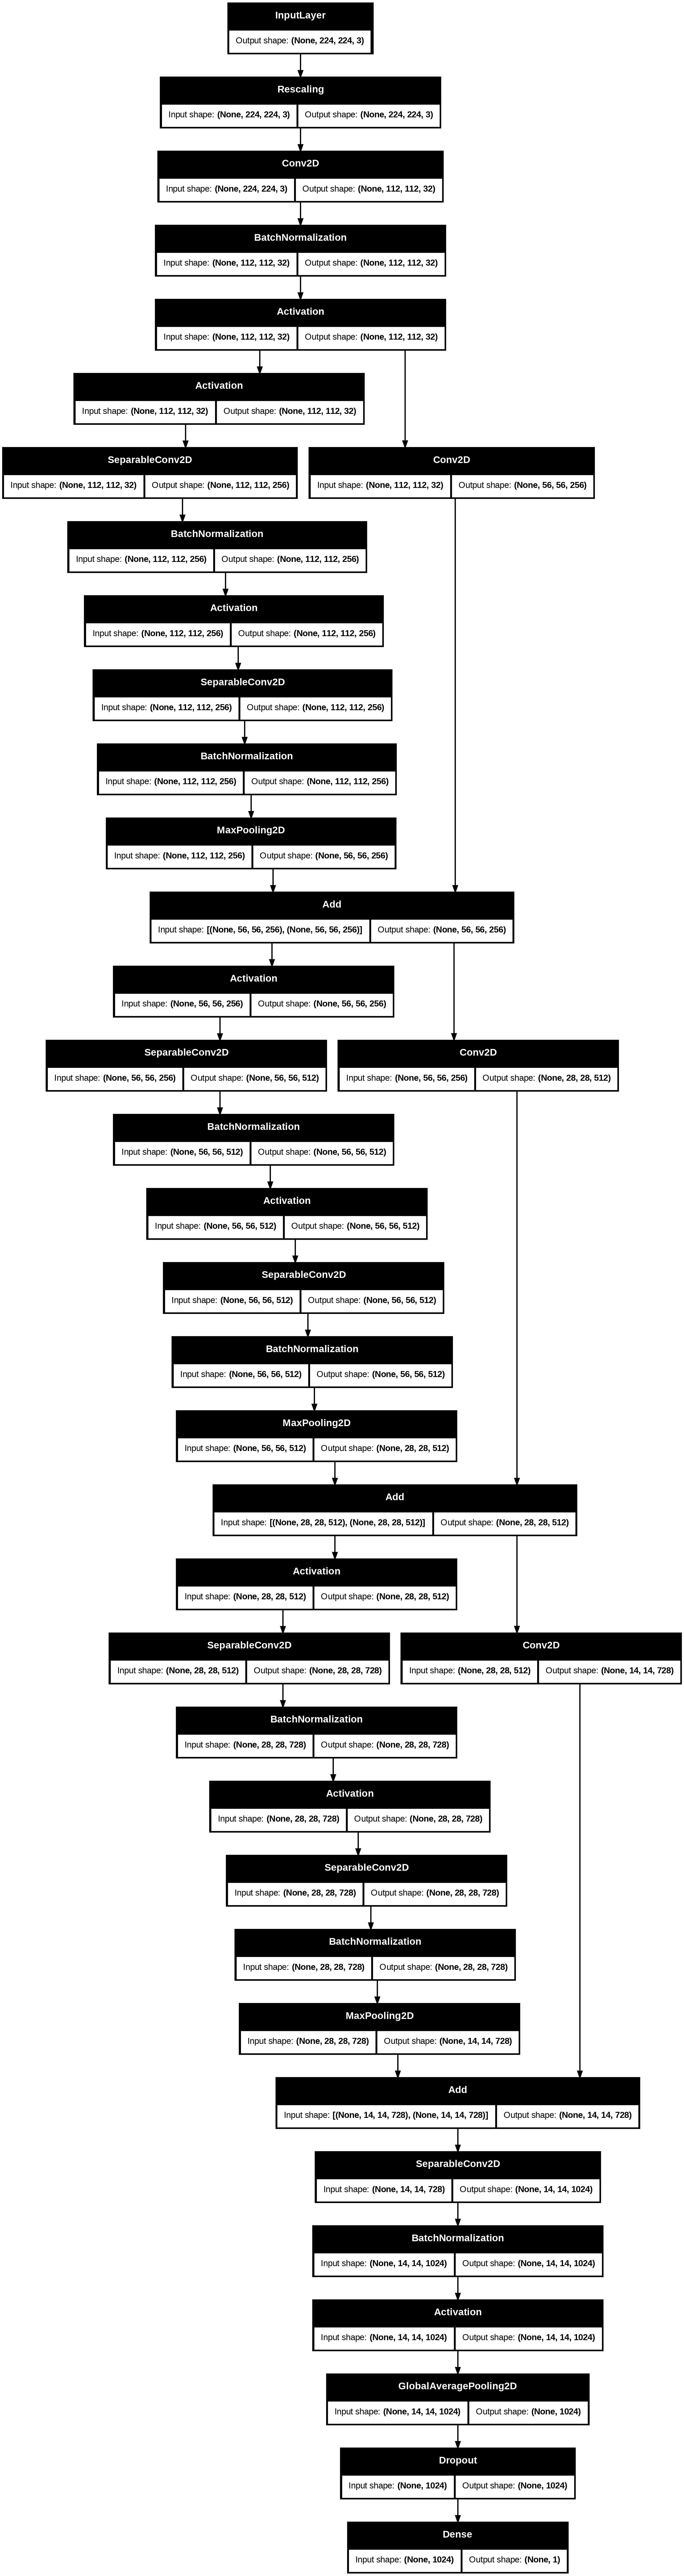

In [ ]:
image_size = (224, 224)

# Build Model

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Enable mixed precision training for faster performance
mixed_precision.set_global_policy('mixed_float16')

# Optimize data loading (assuming train_generator and val_generator are tf.data.Dataset objects)
train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


NameError: name 'train_dataset' is not defined

In [ ]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_acc', factor = 0.1, patience = 2)
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
tf.config.optimizer.set_jit(True)
history=model.fit(train_generator,
          validation_data=val_generator,
          callbacks=callbacks,
          epochs = epochs)
model.save('/content/drive/MyDrive/AI/scratch2.keras')

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


446/446 ━━━━━━━━━━━━━━━━━━━━ 12836s 28s/step - acc: 0.8446 - loss: 0.3240 - val_acc: 0.6885 - val_loss: 0.6960 - learning_rate: 3.0000e-04
Epoch 2/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 404s 894ms/step - acc: 0.9964 - loss: 0.0138 - val_acc: 0.6885 - val_loss: 1.8609 - learning_rate: 3.0000e-04
Epoch 3/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 392s 869ms/step - acc: 0.9972 - loss: 0.0109 - val_acc: 0.6874 - val_loss: 1.8210 - learning_rate: 3.0000e-04
Epoch 4/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 439s 864ms/step - acc: 0.9990 - loss: 0.0034 - val_acc: 0.6885 - val_loss: 2.7901 - learning_rate: 3.0000e-05


In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    directory='/path/to/test/directory',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

In [ ]:
import pickle
with open('/content/drive/MyDrive/AI/Skin Cancer/Skin Cancer/training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

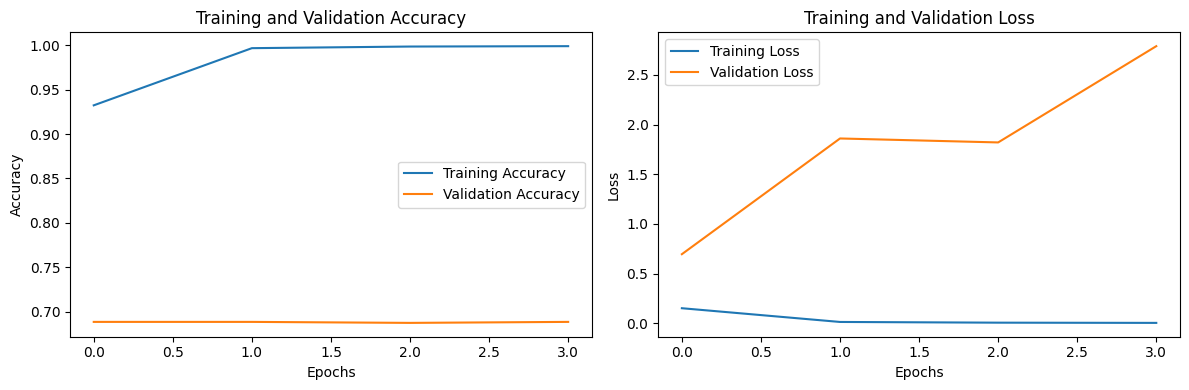

In [ ]:
import pickle
import matplotlib.pyplot as plt

# Load the training history
with open('/content/drive/MyDrive/AI/Skin Cancer/Skin Cancer/training_history.pkl', 'rb') as file:
    history_dict = pickle.load(file)

plt.figure(figsize=(12, 4))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_dict['acc'], label='Training Accuracy') # Changed 'accuracy' to 'acc'
plt.plot(history_dict['val_acc'], label='Validation Accuracy') # Changed 'val_accuracy' to 'val_acc'
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

AttributeError: module 'keras.api.backend' has no attribute 'expand_dims'

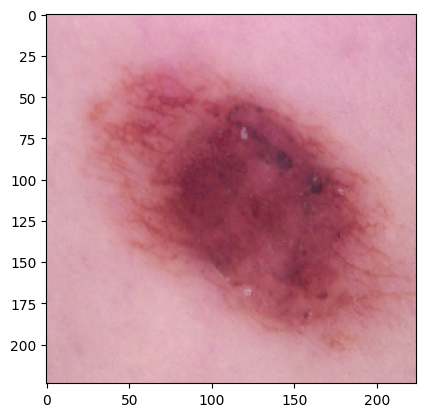

In [ ]:
images, labels = next(train_generator)
img = images[1]
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.backend.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.backend.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% other and {100 * score:.2f}% melenoma.")
print("Predictions:", predictions)
print("Score:", score)
print("Image shape:", img.shape)
print("Label value:", labels[1])

In [ ]:
tf.keras.metrics.AUC(
    num_thresholds=200,
    curve='ROC',
    summation_method='interpolation',
    name=None,
    dtype=None,
    thresholds=None,
    multi_label=False,
    num_labels=None,
    label_weights=None,
    from_logits=False
)

model.compile(optimizer='sgd',
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[keras.metrics.AUC()])

NameError: name 'model' is not defined

In [ ]:
tf.math.confusion_matrix(
    labels,
    predictions,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)

In [6]:
model = tf.keras.models.load_model('/content/drive/MyDrive/AI/scratch.keras')
predict = np.argmax(model.predict(val_generator), axis=1)
predicted_classes = np.argmax(predict)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 96 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


112/112 ━━━━━━━━━━━━━━━━━━━━ 1028s 9s/step


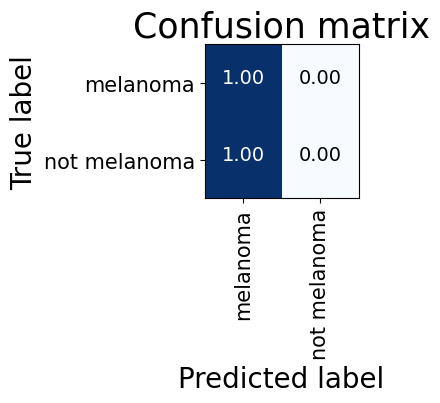

In [7]:
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
def plot_confusion_matrix(actual, predicted):

    cm = confusion_matrix(actual, predicted)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(2,2))
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix', fontsize=25)

    tick_marks = np.arange(2)
    classes = ['melanoma', 'not melanoma']
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    plt.show()


plot_confusion_matrix(val_generator.classes, predict)

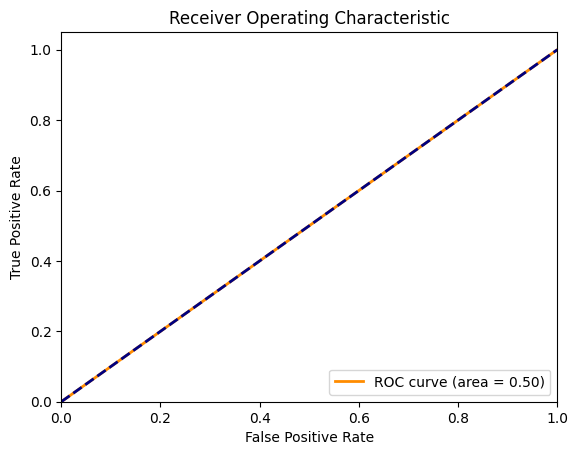

In [9]:
# Calculate ROC Curve and AUC
fpr, tpr, _ = roc_curve(val_generator.classes, predict)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()